# Basic of object detection program using OpenVINO

You will learn the basic of object detection program using OpenVINO in through this exercise.

Here, we'll go through a simple object detection progam using SSD(Single Shot multi-box Detection) model and learn how it works.

### Installing required Python packages
We'll use `matplotlib` to display image data in this exercise. Let's install `matplotlib`.

In [ ]:
# Linux
!pip3 install matplotlib

In [1]:
# Windows
!pip install matplotlib

### Preparing an input image and label text data files
First, let's prepare imput image file and class label text file. Those files are in the OpenVINO install directory. We'll simply copy them to the current working directory.

In [ ]:
# Linux
!cp $INTEL_OPENVINO_DIR/deployment_tools/demo/car_1.bmp .
!cp $INTEL_OPENVINO_DIR/deployment_tools/inference_engine/samples/python/voc_labels.txt .

In [2]:
# Windows 
!copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car_1".bmp .
!copy "%INTEL_OPENVINO_DIR%\deployment_tools\inference_engine\samples\python\voc_labels.txt" .

        1 個のファイルをコピーしました。
        1 個のファイルをコピーしました。


Show the image file and check the picture.  
**Note:** `IPython.display.Image` doesn't support `.bmp` format, so we use `OpenCV` and `matplotlib` this time.

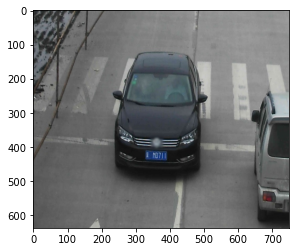

In [3]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('car_1.bmp')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

### Preparing a DL model for inferencing
Download a DL model for image classification using `Model downloader` and convert it into OpenVINO IR model with `Model converter`.  
We'll use `mobilenet-ssd` model for this practice.

In [4]:
!python3 $INTEL_OPENVINO_DIR/deployment_tools/tools/model_downloader/downloader.py --name mobilenet-ssd
!python3 $INTEL_OPENVINO_DIR/deployment_tools/tools/model_downloader/converter.py  --name mobilenet-ssd --precisions FP16
!ls public/mobilenet-ssd/FP16 -l

Python was not found but can be installed from the Microsoft Store: https://go.microsoft.com/fwlink?linkID=2082640
Python was not found but can be installed from the Microsoft Store: https://go.microsoft.com/fwlink?linkID=2082640
'ls' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。


In [5]:
!python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\downloader.py" --name mobilenet-ssd
!python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\converter.py"  --name mobilenet-ssd --precisions FP16
!dir public\mobilenet-ssd\FP16

################|| Downloading models ||################

========== Downloading C:\Users\yas_s\Documents\Intel\OpenVINO\openvino-workshop-en\public\mobilenet-ssd\mobilenet-ssd.prototxt

========== Downloading C:\Users\yas_s\Documents\Intel\OpenVINO\openvino-workshop-en\public\mobilenet-ssd\mobilenet-ssd.caffemodel
... 4%, 1024 KB, 3282 KB/s, 0 seconds passed
... 9%, 2048 KB, 3362 KB/s, 0 seconds passed
... 13%, 3072 KB, 3170 KB/s, 0 seconds passed
... 18%, 4096 KB, 3047 KB/s, 1 seconds passed
... 22%, 5120 KB, 3182 KB/s, 1 seconds passed
... 27%, 6144 KB, 3331 KB/s, 1 seconds passed
... 31%, 7168 KB, 3476 KB/s, 2 seconds passed
... 36%, 8192 KB, 3566 KB/s, 2 seconds passed
... 40%, 9216 KB, 3662 KB/s, 2 seconds passed
... 45%, 10240 KB, 3702 KB/s, 2 seconds passed
... 49%, 11264 KB, 3678 KB/s, 3 seconds passed
... 54%, 12288 KB, 3623 KB/s, 3 seconds passed
... 58%, 13312 KB, 3565 KB/s, 3 seconds passed
... 63%, 14336 KB, 3556 KB/s, 4 seconds passed
... 67%, 15360 KB, 3574 KB/s, 4 seco

----
The Python inferencing code starts from here.

### Importing required Python modules
At first, let's import required Python modules.

In [6]:
import cv2
import numpy as np
from openvino.inference_engine import IENetwork, IECore

### Reading class label text file

In [7]:
label = open('voc_labels.txt').readlines()

### Creating an Inference Engine core object and do some preparation
- Create Inference Engine core object
- Read IR model data
- Information extraction from input and output blob (=buffers)

In [8]:
# Create an Inference Engine core object
ie = IECore()

# Read an IR model data to memory
model = './public/mobilenet-ssd/FP16/mobilenet-ssd'
net = IENetwork(model=model+'.xml', weights=model+'.bin')

# Obtain the name of the input and output blob, and input blob shape
input_blob_name  = list(net.inputs.keys())[0]
output_blob_name = list(net.outputs.keys())[0]
batch,channel,height,width = net.inputs[input_blob_name].shape

### Loading model data to the IE core object
Load the model data to the IE core object. The `CPU` is specified as the processor to use for infrencing job.  

In [9]:
exec_net = ie.load_network(network=net, device_name='CPU', num_requests=1)

### Reading and manipulate input image
Read the input image file and resize and transform it to fit it for input blob of the DL model using OpenCV.

In [10]:
print('input blob: name="{}", N={}, C={}, H={}, W={}'.format(input_blob_name, batch, channel, height, width))
img    = cv2.imread('car_1.bmp')
in_img = cv2.resize(img, (width,height))
in_img = in_img.transpose((2, 0, 1))
in_img = in_img.reshape((1, channel, height, width))

input blob: name="data", N=1, C=3, H=300, W=300


### Running inference  
The `infer()` API is a blocking function and the control will be kept waited until the inferencing task is completed.  
Input data can be passed with a dictionary object in `{input_blob_name:input_data}` format.

**IMPORTANT:** As you may have already noticed, the Python code up to this point is almost identical with the one for image classification code in the previous exercise (model, label and input image file names are the only difference). OpenVINO application is very simple and most of the code is common for different models, and only result parsing and processing code are specialized for the model.

In [11]:
res = exec_net.infer(inputs={input_blob_name: in_img})

### Displaying the inference result  
The `mobilenet-ssd` model outputs 100 object candidates (regardless how many objects are in a picture) and each object has 7 parameters (shape of the output blob is [1,1,100,7]).  
The object parameter represents [`id`, `class#`, `confidence`, `xmin`, `ymin`, `xmax`, `ymax`].  
`class#` represents class number, `confidence` means the 'likeness' to the class in value ranging from 0.0 to 1.0 (1.0=100%). (`xmin`,`ymin`)-(`xmax`,`ymax`) is the top-left and right-bottom coordination of the bounding box for the object. The coordinate is in range from 0.0 to 1.0, so, multiplies the image height and width to convert it into the pixel coordination in the picture.  
The code checks the confidence and draw bounding box and label on the image when the confidence is higher than 0.6 (60%).

Displaying the rsult image at the end.

output blob: name="detection_out", shape=[1, 1, 100, 7]


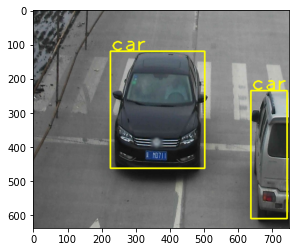

In [12]:
print('output blob: name="{}", shape={}'.format(output_blob_name, net.outputs[output_blob_name].shape))
result = res[output_blob_name][0][0]
img_h, img_w, _ = img.shape
for obj in result:
    imgid, clsid, confidence, x1, y1, x2, y2 = obj
    if confidence>0.6:
        x1 = int(x1 * img_w)
        y1 = int(y1 * img_h)
        x2 = int(x2 * img_w)
        y2 = int(y2 * img_h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,255), thickness=4 )
        cv2.putText(img, label[int(clsid)][:-1], (x1, y1), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(0,255,255), thickness=4)

%matplotlib inline
import matplotlib.pyplot as plt
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

----
Now, you have learnt how object detection program using OpenVINO works.  

As you have already saw, most of the code in the OpenVINO application is common except the result processing part.  
What you need to know to develop an application using OpenVINO is the input and output blob format. You don't need to know the details or the internal behavior of the model to develop an application for OpenVINO.

## Next => Basic of asynchronous inferencing - [classification-async-single.ipynb](./classification-async-single.ipynb)